# Vertical Coord Transforms

I need to figure out how to take a ds_gridded with dimensions `density`, `lon`, `lat` and transform it to have dimensions `av isopycnal depth`, `lon`, `lat`. I've done this before for data with dimensions `density`, `N_PROF`. I don't think this will be very difficult?? Hoping I just have to 
1. flatten the dataset into having dimensions `density`, `N_PROF`
2. perform calculations with established functions
3. reshape the dataset back into the original dimensions of `density`, `lon`, `lat`

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [2]:
def ds_pmean_smooth(ds_rho, roll, dim1='N_PROF_NEW', dim2='PRES_INTERPOLATED', dim3='rho_grid'):
    '''Takes an xarray in density space and returns a smoothed isopycnal grid.
    
    ds_rho: xarray with density coordinate
    roll: smoothing factor
    dim1: profile dimension, default='N_PROF_NEW'
    dim2: pressure dimension, default='PRES_INTERPOLATED'
    dim3: density dimension, default='rho_grid'
    '''
    
    Pmean_smooth = ds_rho[dim2].mean(dim1).rolling({dim3:roll}, center=True).mean()
    
    return Pmean_smooth

In [3]:
def ds_pmean_var(ds_rho, Pmean_smooth, Pmax, variable3='SPICE', dim1='N_PROF_NEW'):
    '''Takes an xarray in density space and smoothed isopycnal grid and returns an xarray with the variable interpolated to that grid.
    
    ds_rho: xarray with density coordinate
    Pmean_smooth: smoothed isopycnal grid
    Pmax: maximum depth value for plotting
    variable3: variable to be interpolated, default='SPICE'
    dim1: profiles dimension, default='N_PROF_NEW'
    '''
    
    N_PROF_NEW_ind = 0

    Spice_on_Pmean = func_var_int_pmean(ds_rho.isel({dim1:N_PROF_NEW_ind}), Pmean_smooth, Pmax, variable=variable3, dim1=dim1)
    
    for N_PROF_NEW_ind in range(1, len(ds_rho[dim1])):
        Spice_on_Pmean = xr.concat([Spice_on_Pmean, func_var_int_pmean(ds_rho.isel({dim1:N_PROF_NEW_ind}), Pmean_smooth, Pmax, variable=variable3, dim1=dim1)]
                              , dim=dim1)
        
    return Spice_on_Pmean


In [13]:
K_e_3dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/K_e_CT.nc')
ds_gridded_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_rho.nc')
ds_gridded = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_x.nc')

Text(0.5, 1.0, 'Depth, density=27.5m')

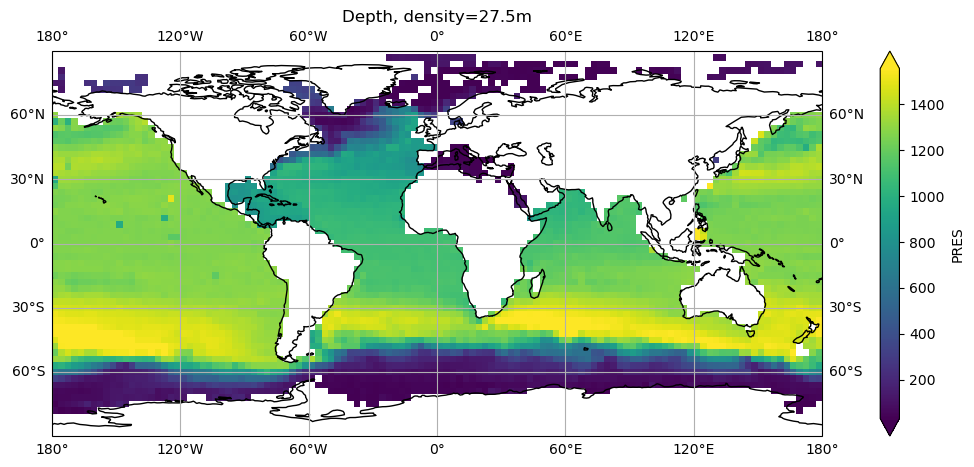

In [14]:
density = 27.5
ds = ds_gridded_rho.PRES

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), robust=True)
plt.title(f'Depth, density={density}m')

In [72]:
prof = ds_gridded_rho.sel(lon=-40, method='nearest').sel(lat=-50, method='nearest').expand_dims(dim={'N_PROF':[0]})
prof_x = ds_gridded.sel(lon=-40, method='nearest').sel(lat=-50, method='nearest').expand_dims(dim={'N_PROF':[0]})
prof

<xarray.Dataset> Size: 141kB
Dimensions:  (N_PROF: 1, density: 3200)
Coordinates:
  * N_PROF   (N_PROF) int64 8B 0
    lon      float64 8B -40.5
    lat      float64 8B -51.0
  * density  (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
Data variables:
    CT       (N_PROF, density) float64 26kB nan nan nan nan ... nan nan nan nan
    SA       (N_PROF, density) float64 26kB nan nan nan nan ... nan nan nan nan
    SIG0     (N_PROF, density) float64 26kB nan nan nan nan ... nan nan nan nan
    SPICE    (N_PROF, density) float64 26kB nan nan nan nan ... nan nan nan nan
    PRES     (N_PROF, density) float32 13kB nan nan nan nan ... nan nan nan nan

In [73]:
#Pmean_smooth = prof.PRES.rolling(density= 80, center=True, min_periods=1).mean()
Pmean_smooth = ds_gridded_rho.PRES.sel(lon=-40, method='nearest').sel(lat=-50, method='nearest').expand_dims(dim={'N_PROF':[0]})

In [74]:
print(Pmean_smooth)

<xarray.DataArray 'PRES' (N_PROF: 1, density: 3200)> Size: 13kB
array([[nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * N_PROF   (N_PROF) int64 8B 0
    lon      float64 8B -40.5
    lat      float64 8B -51.0
  * density  (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0


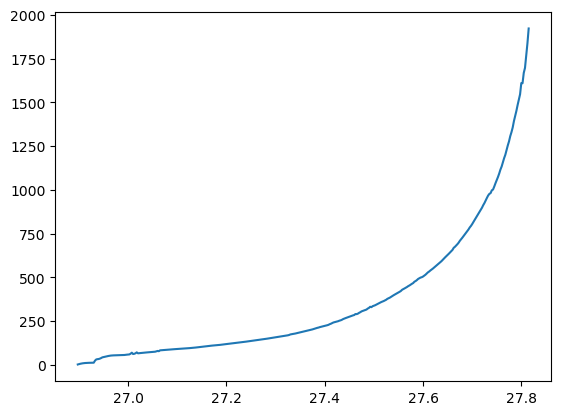

In [75]:
plt.plot(Pmean_smooth.density, Pmean_smooth[0])

In [76]:
def prepare_monotonic_interpolation_coords(P: xr.DataArray) -> xr.DataArray:
    """
    Takes a 1D or squeezed 2D pressure array and returns a strictly increasing,
    NaN-free coordinate for interpolation.
    """
    # Squeeze and flatten
    P_flat = P.squeeze().dropna(dim='density')

    # Sort values
    sorted_idx = np.argsort(P_flat.values)
    P_sorted = P_flat.isel(density=sorted_idx)

    # Drop duplicate or non-increasing values
    dx = np.diff(P_sorted.values)
    monotonic_mask = dx > 0
    if not np.all(monotonic_mask):
        valid_idx = np.concatenate(([True], monotonic_mask))
        P_sorted = P_sorted.isel(density=valid_idx)

    return P_sorted


In [77]:
def func_var_int_pmean(ds, Pmean_smooth, Pmax, variable='SPICE', dim1='N_PROF_NEW',): 
    '''Takes a profile and mean isopycnal grid and returns a profile with the variable interpolated to that grid.
    
    ds: profile in depth space
    Pmean_smooth: smoothed mean isopycnal grid
    Pmax: maximum depth value for plotting
    variable: variable to be interpolated, default='SPICE'
    dim1: profile/distance dimension, default='N_PROF_NEW'
    '''
    
    Pmean_grid = np.linspace(0,2000,1001)
    
    ds_nonan = ds[variable].where(~np.isnan(ds[variable]) & ~np.isnan(Pmean_smooth), drop=True).squeeze()
    Pmean_nonan = prepare_monotonic_interpolation_coords(Pmean_smooth.where(~np.isnan(ds[variable]), drop=True))
    
    if len(ds_nonan) > 2:
       
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values, extrapolate=False)
        
        ds_on_Pmean = f(Pmean_grid)
        print(f"Interpolated CT max depth: {Pmean_grid[~np.isnan(ds_on_Pmean)][-1]}")

    else:
        ds_on_Pmean = np.nan*Pmean_grid
        
    ds_pmean =  xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', dim1],
                        coords = {'Pmean': Pmean_grid, dim1: ds[dim1].values}).rename(variable)
    
    return ds_nonan, Pmean_nonan, ds_pmean

In [78]:
ds_nonan, Pmean_nonan, CT_on_Pmean = func_var_int_pmean(prof, Pmean_smooth, Pmax=2000, variable='CT', dim1='N_PROF')

Interpolated CT max depth: 1920.0


In [79]:
prof.CT.where(~np.isnan(prof.CT), drop=True)

<xarray.DataArray 'CT' (N_PROF: 1, density: 368)> Size: 3kB
array([[3.16843947, 3.15192747, 3.13806183, 3.12661143, 3.11734514,
        3.11003184, 3.1044404 , 3.10033969, 3.0974986 , 3.09568599,
        3.09467074, 3.09422173, 3.09410782, 3.08890818, 3.05432641,
        3.02099127, 3.00042629, 2.98588943, 2.96387967, 2.93818506,
        2.89732717, 2.87127189, 2.85280541, 2.83613742, 2.81317534,
        2.7887709 , 2.76480031, 2.74262351, 2.72209438, 2.70346478,
        2.6861717 , 2.66984423, 2.65411338, 2.63861013, 2.6229655 ,
        2.60681048, 2.58977609, 2.57149332, 2.55076563, 2.52841903,
        2.51008459, 2.49589701, 2.47535676, 2.40005396, 2.30404033,
        2.42548075, 2.39739941, 2.33273578, 2.22626232, 2.3398674 ,
        2.32668969, 2.30201601, 2.28077968, 2.26020183, 2.23909051,
        2.21765815, 2.19611719, 2.17468004, 2.15355913, 2.13296688,
        2.11311572, 2.09506573, 2.08250081, 2.06599665, 2.00837744,
        1.96045884, 1.99167419, 1.87815315, 1.86347066, 1.84601128,
        1.82638645, 1.80759634, 1.78894223, 1.7697126 , 1.7506501 ,
        1.7331115 , 1.7179686 , 1.70423503, 1.69158235, 1.67978053,
        1.66889845, 1.65919589, 1.64994869, 1.64038893, 1.62974842,
        1.61684181, 1.60290188, 1.59068478, 1.5810442 , 1.57263185,
        1.56443754, 1.55545108, 1.5448272 , 1.53278264, 1.51962792,
        1.50518178, 1.48890284, 1.4729869 , 1.45889823, 1.44550251,
...
        2.18567555, 2.18548177, 2.18438181, 2.18361384, 2.18610533,
        2.18369234, 2.18035238, 2.17645882, 2.17213039, 2.16923663,
        2.16291638, 2.15831945, 2.1559285 , 2.15524895, 2.15372284,
        2.1498344 , 2.14495324, 2.14129171, 2.13807891, 2.13399579,
        2.1312592 , 2.12886674, 2.12355404, 2.11986659, 2.11715314,
        2.11365614, 2.10996413, 2.10696033, 2.10210275, 2.09629737,
        2.09077018, 2.08575614, 2.08095415, 2.07576938, 2.06949467,
        2.06320941, 2.05347117, 2.04711692, 2.04079956, 2.03438374,
        2.02797744, 2.02530741, 2.01857645, 2.01170839, 2.00364934,
        1.99577151, 1.98698649, 1.97862904, 1.97092336, 1.9605949 ,
        1.95290924, 1.94590871, 1.93538778, 1.92616899, 1.91634261,
        1.90530885, 1.89473721, 1.88425314, 1.87357038, 1.86433556,
        1.85433645, 1.84175357, 1.82945047, 1.8163815 , 1.80326481,
        1.79024769, 1.77343542, 1.75660075, 1.74234316, 1.72915191,
        1.71363027, 1.69855421, 1.68203973, 1.66298686, 1.64428745,
        1.62523984, 1.60028155, 1.57917037, 1.5612568 , 1.53443113,
        1.51113859, 1.48774697, 1.45843561, 1.43787014, 1.41503843,
        1.38397519, 1.35160046, 1.31805956, 1.29258828, 1.2621083 ,
        1.22333205, 1.15747527, 1.15693126, 1.09433854, 1.05510679,
        1.00014251, 0.93060213, 0.86728552]])
Coordinates:
  * N_PROF   (N_PROF) int64 8B 0
    lon      float64 8B -40.5
    lat      float64 8B -51.0
  * density  (density) float64 3kB 26.9 26.9 26.9 26.91 ... 27.81 27.81 27.82

In [80]:
Pmean_smooth.where(~np.isnan(Pmean_smooth), drop=True)

<xarray.DataArray 'PRES' (N_PROF: 1, density: 368)> Size: 1kB
array([[   2.3242943,    4.47355  ,    6.2783465,    7.768768 ,
           8.974898 ,    9.926822 ,   10.654621 ,   11.188383 ,
          11.558188 ,   11.794124 ,   11.926272 ,   11.984717 ,
          11.999543 ,   12.503869 ,   23.917927 ,   30.866362 ,
          32.693676 ,   33.54661  ,   35.79567  ,   38.92762  ,
          42.989094 ,   44.707317 ,   46.415165 ,   48.247143 ,
          49.591198 ,   51.010197 ,   52.269028 ,   53.278687 ,
          53.96917  ,   54.319256 ,   54.574123 ,   54.76114  ,
          54.90633  ,   55.035736 ,   55.175396 ,   55.35134  ,
          55.589607 ,   55.916237 ,   56.577087 ,   57.640297 ,
          58.41197  ,   58.95577  ,   59.79145  ,   63.9656   ,
          69.69941  ,   62.210968 ,   63.350388 ,   66.328415 ,
          71.57911  ,   66.00197  ,   66.56509  ,   67.58409  ,
          68.377716 ,   69.07882  ,   69.75618  ,   70.415016 ,
          71.06055  ,   71.698006 ,   72.3326   ,   72.96957  ,
          73.61411  ,   74.2382   ,   74.69528  ,   75.3247   ,
          77.65837  ,   79.631546 ,   78.11253  ,   83.11664  ,
          83.724144 ,   84.32487  ,   84.93033  ,   85.47676  ,
          86.03773  ,   86.63442  ,   87.232605 ,   87.81127  ,
          88.35754  ,   88.88543  ,   89.39326  ,   89.87753  ,
...
         568.3684   ,  573.53735  ,  579.6728   ,  585.71375  ,
         592.38116  ,  600.0078   ,  608.1839   ,  614.42456  ,
         621.06116  ,  628.14764  ,  635.05414  ,  642.1548   ,
         649.6626   ,  657.0109   ,  668.9782   ,  674.70184  ,
         682.08514  ,  689.64044  ,  698.2691   ,  709.11444  ,
         717.5359   ,  726.57935  ,  736.0777   ,  744.97577  ,
         755.29205  ,  764.5922   ,  773.5676   ,  784.9324   ,
         793.6862   ,  804.2261   ,  816.5897   ,  827.8448   ,
         839.4001   ,  850.40735  ,  861.6513   ,  874.49176  ,
         886.32764  ,  897.9537   ,  912.44415  ,  924.65674  ,
         939.5427   ,  953.7827   ,  967.5924   ,  976.9086   ,
         981.303    ,  997.19415  , 1001.9038   , 1019.1706   ,
        1038.206    , 1055.0798   , 1073.2667   , 1093.0204   ,
        1115.5214   , 1133.1891   , 1157.264    , 1180.7091   ,
        1200.421    , 1227.8342   , 1253.8201   , 1276.9889   ,
        1306.7837   , 1329.5283   , 1356.4503   , 1392.9148   ,
        1421.0173   , 1451.0558   , 1484.7899   , 1514.7219   ,
        1546.0314   , 1610.1063   , 1609.0391   , 1668.3231   ,
        1696.8436   , 1765.7231   , 1837.5614   , 1921.9711   ]],
      dtype=float32)
Coordinates:
  * N_PROF   (N_PROF) int64 8B 0
    lon      float64 8B -40.5
    lat      float64 8B -51.0
  * density  (density) float64 3kB 26.9 26.9 26.9 26.91 ... 27.81 27.81 27.82

Text(0.5, 1.0, '')

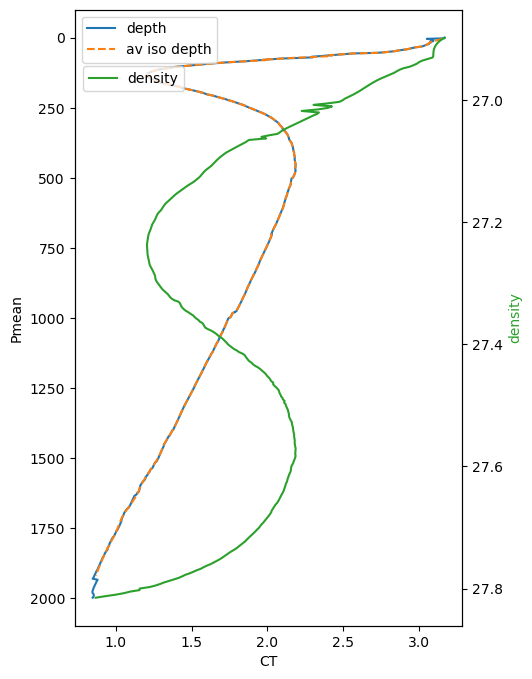

In [81]:
plt.figure(figsize=(5,8))
prof_x.CT.plot(y='PRES_INTERPOLATED',label='depth')
CT_on_Pmean.plot(y='Pmean',label='av iso depth',linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('')

plt.twinx()
prof.CT.plot(y='density',label='density',color='tab:green')
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(0.3,0.92))
plt.ylabel('density',color='tab:green')
plt.title('')